# Question-1 LDA (Topic Identification)

In [1]:
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
nltk.download('wordnet')      #download if using this module for the first time


from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
nltk.download('stopwords')    #download if using this module for the first time


#For Gensim
import gensim
import string
from gensim import corpora
from gensim.corpora.dictionary import Dictionary
from nltk.tokenize import word_tokenize
import pandas as pd

import spacy
from textpipeliner import PipelineEngine, Context
from textpipeliner.pipes import *

nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sivap\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sivap\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
sentence = "US President Donald Trump said Iran's Supreme Leader Ayatollah Ali Khamenei should be very \
            careful about what he says after Khamenei harshly criticized the United States \
            in a Friday prayers sermon in Tehran."

Removing StopWords and Punctuation

In [3]:
stopwords = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

def clean(document):
    stopwordremoval = " ".join([i for i in document.lower().split() if i not in stopwords])
    punctuationremoval = ''.join(ch for ch in stopwordremoval if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punctuationremoval.split())
    return stopwordremoval

final_doc = [clean(sentence).split()]

LDA Model

In [4]:
dictionary = corpora.Dictionary(final_doc)

DT_matrix = [dictionary.doc2bow(doc) for doc in final_doc]

Lda_object = gensim.models.ldamodel.LdaModel

In [5]:
lda_model_1 = Lda_object(DT_matrix, num_topics=1, id2word = dictionary)
print(lda_model_1.print_topics(num_topics=1, num_words=5))

[(0, '0.070*"khamenei" + 0.047*"ayatollah" + 0.047*"says" + 0.047*"sermon" + 0.047*"ali"')]


In [6]:
top_words_per_topic = []
for t in range(lda_model_1.num_topics):
    top_words_per_topic.extend([(t, ) + x for x in lda_model_1.show_topic(t, topn = 10)])

print('Subject ',' '.join(list(pd.DataFrame(top_words_per_topic, columns=['Topic', 'Word', 'P'])['Word'])))

Subject  khamenei says ayatollah ali sermon leader states united supreme prayers


### Extracting Subject, verb, object

In [7]:
doc = nlp(sentence)

In [8]:
pipes_structure = [SequencePipe([FindTokensPipe("VERB/nsubj/*"),
                                 NamedEntityFilterPipe(),
                                 NamedEntityExtractorPipe()]),
                   FindTokensPipe("VERB"),
                   AnyPipe([SequencePipe([FindTokensPipe("VBD/dobj/NNP"),
                                          AggregatePipe([NamedEntityFilterPipe("GPE"), 
                                                NamedEntityFilterPipe("PERSON")]),
                                          NamedEntityExtractorPipe()]),
                            SequencePipe([FindTokensPipe("VBD/**/*/pobj/NNP"),
                                          AggregatePipe([NamedEntityFilterPipe("LOC"), 
                                                NamedEntityFilterPipe("PERSON")]),
                                          NamedEntityExtractorPipe()])])]

engine = PipelineEngine(pipes_structure, Context(doc))
result = engine.process()

In [9]:
result

[([Donald, Trump], [said], [])]

In [10]:
print('Subject of Passage is:', ' '.join(str(v) for v in result[0][0]))

Subject of Passage is: Donald Trump


# Question-2 SpeechRecognition

In [11]:
from os import path
from pydub import AudioSegment
from scipy.io import wavfile
import numpy as np
# files                                                                         
src = r'C:\Users\sivap\Downloads\E150917_4_IND_HARYANA_RYAN_MURDER.mp3'
dst = "test.wav"

# convert wav to mp3                                                            
sound = AudioSegment.from_mp3(src)
sound.export(dst, format="wav")

<_io.BufferedRandom name='test.wav'>

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import wave
import sys

# Load the data and calculate the time of each sample
samplerate, data = wavfile.read('test.wav')
times = np.arange(len(data))/float(samplerate)

# Make the plot
# You can tweak the figsize (width, height) in inches
plt.figure(figsize=(30, 4))
plt.fill_between(times, data[:,0], data[:,1], color='k') 
plt.xlim(times[0], times[-1])
plt.xlabel('time (s)')
plt.ylabel('amplitude')
# You can set the format by changing the extension
# like .pdf, .svg, .eps
plt.savefig('plot.png', dpi=100)
plt.show()

C:\Users\sivap\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10


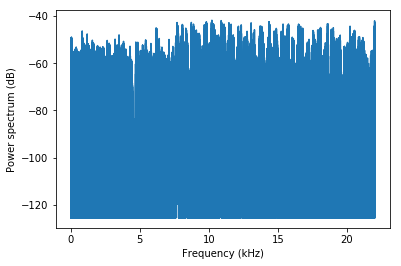

In [13]:
# spectrum

fs, data = wavfile.read('test.wav')
from scipy.fftpack import fft # fourier transform
n = len(data) 
AudioFreq = fft(data)
AudioFreq = AudioFreq[0:int(np.ceil((n+1)/2.0))] #Half of the spectrum
MagFreq = np.abs(AudioFreq) # Magnitude
MagFreq = MagFreq / float(n)
# power spectrum
MagFreq = MagFreq**2
if n % 2 > 0: # ffte odd 
    MagFreq[1:len(MagFreq)] = MagFreq[1:len(MagFreq)] * 2
else:# fft even
    MagFreq[1:len(MagFreq) -1] = MagFreq[1:len(MagFreq) - 1] * 2 

plt.figure()
freqAxis = np.arange(0,int(np.ceil((n+1)/2.0)), 1.0) * (fs / n);
plt.plot(freqAxis/1000.0, 10*np.log10(MagFreq)) #Power spectrum
plt.xlabel('Frequency (kHz)'); plt.ylabel('Power spectrum (dB)');

Splitting audio file

In [14]:
from pydub import AudioSegment
from pydub.utils import make_chunks

myaudio = AudioSegment.from_file("test.wav" , "wav") 
chunk_length_ms = 15000 # pydub calculates in millisec
chunks = make_chunks(myaudio, chunk_length_ms) #Make chunks of one sec

#Export all of the individual chunks as wav files

for i, chunk in enumerate(chunks):
    chunk_name = "chunk{0}.wav".format(i)
    print("exporting", chunk_name)
    chunk.export(chunk_name, format="wav")

exporting chunk0.wav
exporting chunk1.wav
exporting chunk2.wav
exporting chunk3.wav
exporting chunk4.wav
exporting chunk5.wav
exporting chunk6.wav
exporting chunk7.wav
exporting chunk8.wav


In [15]:
import speech_recognition as sr
import sys
all_text = []
for i in range(0,8):
    # read filename from arguments
    filename = r'chunk{}.wav'.format(i)

    # initialize the recognizer
    r = sr.Recognizer()
    # open the file
    with sr.AudioFile(filename) as source:
        # listen for the data (load audio to memory)
        audio_data = r.record(source)
        # recognize (convert from speech to text)
        text = r.recognize_google(audio_data)
        all_text.append(text)
audio_text  = ' '.join(all_text)
print('Text from Audio : \n \n', audio_text)

Text from Audio : 
 
 Haryana Chief Minister today matter greeting parents of Pradyuman Thakur 7 year old student who was found murdered at gurugram Ryan International School premises told reporters that he has CBI enquiry in the case and that his government will be taking over the school for the next 3 months Samaj Ke Logon Ne Ek Mang rakhi hai Kis Kisko pyaar ko sampaje CBI jaanch ke liye super jata hai isliye CBI aur kiski immediately High Court dikhayenge Chief Minister is said to have broken down had earlier mat gurugram CP Sandeep they work together updates about the case Pradyuman was founded on Friday last week by a school staff are in washroom on the school campus in bhondsi area near gurugram city with his throat slit the boys family reside in Maruti Kunj Society in the same area last week full Ashok Kumar conductor of a school bus associated with school at least expected to be the killer download The Times news


LDA

In [16]:
final_doc = [clean(audio_text).split()]

In [17]:
dictionary = corpora.Dictionary(final_doc)

DT_matrix = [dictionary.doc2bow(doc) for doc in final_doc]

In [18]:
lda_model_1 = Lda_object(DT_matrix, num_topics=1, id2word = dictionary)
print(lda_model_1.print_topics(num_topics=1, num_words=5))

[(0, '0.034*"school" + 0.019*"cbi" + 0.019*"gurugram" + 0.015*"ke" + 0.015*"last"')]


In [19]:
import pandas as pd
top_words_per_topic = []
for t in range(lda_model_1.num_topics):
    top_words_per_topic.extend([(t, ) + x for x in lda_model_1.show_topic(t, topn = 10)])

print('Sbbject : ', ' '.join(list(pd.DataFrame(top_words_per_topic, columns=['Topic', 'Word', 'P'])['Word'])))

Sbbject :  school cbi gurugram ke last week pradyuman area hai case


### Extracting Subject, Verb, Object from sentence)

In [20]:
audio_doc = nlp(audio_text)

In [21]:
audio_doc

Haryana Chief Minister today matter greeting parents of Pradyuman Thakur 7 year old student who was found murdered at gurugram Ryan International School premises told reporters that he has CBI enquiry in the case and that his government will be taking over the school for the next 3 months Samaj Ke Logon Ne Ek Mang rakhi hai Kis Kisko pyaar ko sampaje CBI jaanch ke liye super jata hai isliye CBI aur kiski immediately High Court dikhayenge Chief Minister is said to have broken down had earlier mat gurugram CP Sandeep they work together updates about the case Pradyuman was founded on Friday last week by a school staff are in washroom on the school campus in bhondsi area near gurugram city with his throat slit the boys family reside in Maruti Kunj Society in the same area last week full Ashok Kumar conductor of a school bus associated with school at least expected to be the killer download The Times news

In [22]:
engine = PipelineEngine(pipes_structure, Context(audio_doc),[1])
result = engine.process()

In [23]:
result

[([], [said], []), ([], [work], []), ([], [reside], [])]

No subject found using spacy

# Question-2 OCR

In [24]:
from PIL import Image 
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

# print(image_to_string(Image.open('test-english.jpg'), lang='eng'))

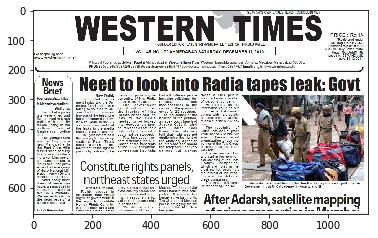

In [25]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('western-times.jpg')
imgplot = plt.imshow(img)


In [26]:
news_article = (pytesseract.image_to_string(Image.open('western-times.jpg')))

In [27]:
print('Text from Image : \n \n', news_article.strip())

Text from Image : 
 
 GUJARAT’S OWN ENGLISH DAILY FOUNDED IN 1967

WESTERN’ TIMES ....

RNIReg. No. 1117267

FOUNDER EDITOR: LATE SHRI RAMU PATEL* EDITOR: NIKUNY PATEL fiageg te sr
Forenaperiog ante ] vou.45 No.172AHMEDABAD SATURDAY, DECEMBER 11,2010 —| Ms Regd, No, GANG 162

\www.westemtimes.co.in issued by SSF AND vad

Printed & Published by :Nikunj Patel at Ahmedabad at Western Times Pross” Wostom House’ Marutnandan Complex, Madalpur, Ahmodabad-380 006.
PHONE : 079-26576037, 26578738 Advertisement: 26576417 advtewestorntimesco.in* Fax: 28577421 Email :english@westerntimes.co.in

(News ) Need to look into Radia tapes leak: Govt

‘media rom publishing the had with different people those audios public
franseripte of Nira Radia including politicians, bu- was certainly a matter

 

  

 

 

Fourseparaists killed

ment Friday told the Su- tapes in the 2G scam. reaucrats and_ of personal concern.
inMeghalayagunfight | Frome Court that twas The government mediapersons in the _ He said that

LDA

In [28]:
final_doc = [clean(news_article).split()]

In [29]:
dictionary = corpora.Dictionary(final_doc)

DT_matrix = [dictionary.doc2bow(doc) for doc in final_doc]

In [30]:
lda_model_1 = Lda_object(DT_matrix, num_topics=1, id2word = dictionary)
print(lda_model_1.print_topics(num_topics=1, num_words=10))

[(0, '0.027*"|" + 0.008*"tata" + 0.007*"radia" + 0.007*"said" + 0.005*"media" + 0.005*"nira" + 0.005*"court" + 0.005*"forces" + 0.005*"friday" + 0.005*"tapes"')]


In [31]:
top_words_per_topic = []
for t in range(lda_model_1.num_topics):
    top_words_per_topic.extend([(t, ) + x for x in lda_model_1.show_topic(t, topn = 10)])

print(' '.join(list(pd.DataFrame(top_words_per_topic, columns=['Topic', 'Word', 'P'])['Word'])))

| tata radia said media nira court forces friday tapes


Extracting Subject, verb, object (Spacy)

In [32]:
audio_doc = nlp(news_article)

In [33]:
engine = PipelineEngine(pipes_structure, Context(audio_doc),[1])
result = engine.process()

In [34]:
result

[([], [Need], []),
 ([], [killed], []),
 ([], [said], []),
 ([], [put], []),
 ([], [killed], []),
 ([], [leak], []),
 ([], [are], []),
 ([], [m], []),
 ([], [Needed], []),
 ([], [_], []),
 ([], [said], [Kumar, Ganguly]),
 ([], [said], []),
 ([], [told], []),
 ([], [took], [[
    , Jace], [Gajingpera]]),
 ([], [are], []),
 ([], [said], []),
 ([], [urged], []),
 ([], [pleted], []),
 ([], [ii], [])]

No subject found using spacy